# Imports

In [124]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, LeaveOneOut, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [125]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Algoritmo

In [126]:
def MLPR(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        model = LinearRegression().fit(y_pred.reshape(-1, 1), y_true)
        slope = model.coef_[0]
        offset = model.intercept_
        r2 = r2_score(y_true, y_pred)
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "R²": r2,
            "Correlation coefficient": correlation_coefficient,
            "RMSE": rmse,
            "MAE": mae,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Slope": slope,
            "Offset": offset
        }

    def display_metrics(title, metrics):
        print(f"=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val

    # Pipeline com ajustes sugeridos
    pipeline = make_pipeline(
    StandardScaler(),
        MLPRegressor(
            hidden_layer_sizes=(10,),     # Uma camada única mais robusta
            activation='tanh',
            solver='adam',
            alpha=0.5,                    # Regularização mais forte
            max_iter=3000,
            random_state=42,
            learning_rate='adaptive',
            learning_rate_init=0.0001,   # Taxa de aprendizado inicial menor
            batch_size=16
        )
)

    # Treinamento e validação
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada com 5 folds
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=10)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results_df = pd.DataFrame({
        "Attribute": [attribute, attribute, attribute],
        "Y": ["Training", "Cross-Validation", "Validation"],
        "R²": [training_metrics["R²"], cv_metrics["R²"], validation_metrics["R²"]],
        "Correlation coefficient": [training_metrics["Correlation coefficient"], cv_metrics["Correlation coefficient"], validation_metrics["Correlation coefficient"]],
        "RMSE": [training_metrics["RMSE"], cv_metrics["RMSE"], validation_metrics["RMSE"]],
        "MAE": [training_metrics["MAE"], cv_metrics["MAE"], validation_metrics["MAE"]],
        "Relative absolute error": [training_metrics["Relative absolute error"], cv_metrics["Relative absolute error"], validation_metrics["Relative absolute error"]],
        "Root relative squared error": [training_metrics["Root relative squared error"], cv_metrics["Root relative squared error"], validation_metrics["Root relative squared error"]],
        "Slope": [training_metrics["Slope"], cv_metrics["Slope"], validation_metrics["Slope"]],
        "Offset": [training_metrics["Offset"], cv_metrics["Offset"], validation_metrics["Offset"]]
    })
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title(f"{filter + " - " + attribute}: Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Predicted - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nReference - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df

# Ajusta saída

In [127]:
infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])


def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre


# MSC - MLPR

=== Training Metrics ===
R²: 0.9472
Correlation coefficient: 0.9740
RMSE: 0.6107
MAE: 0.3915
Relative absolute error: 17.7320
Root relative squared error: 22.9883
Slope: 1.0114
Offset: -0.0578
=== Cross-Validation Metrics ===
R²: 0.3249
Correlation coefficient: 0.7519
RMSE: 2.1826
MAE: 1.6136
Relative absolute error: 73.0818
Root relative squared error: 82.1638
Slope: 0.6619
Offset: 5.2680
=== Validation Metrics ===
R²: 0.5586
Correlation coefficient: 0.8152
RMSE: 1.3981
MAE: 1.1289
Relative absolute error: 65.4989
Root relative squared error: 66.4409
Slope: 0.7283
Offset: 3.9751


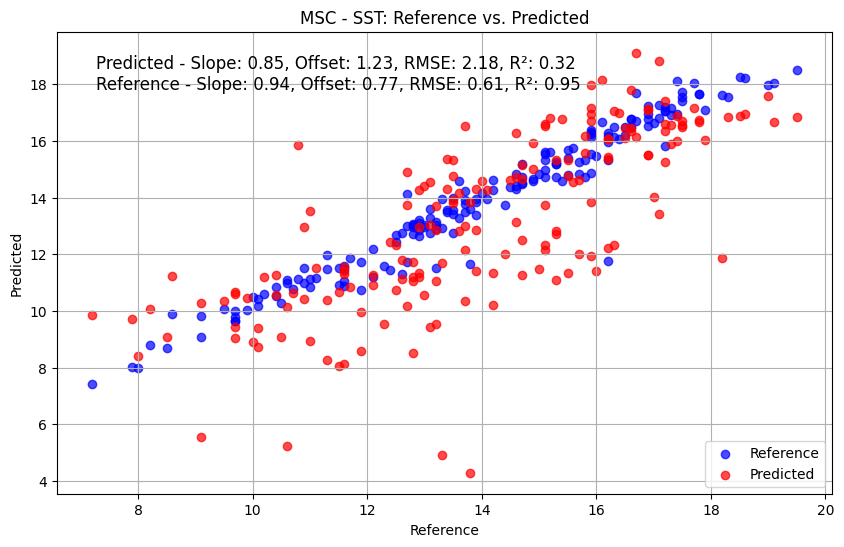

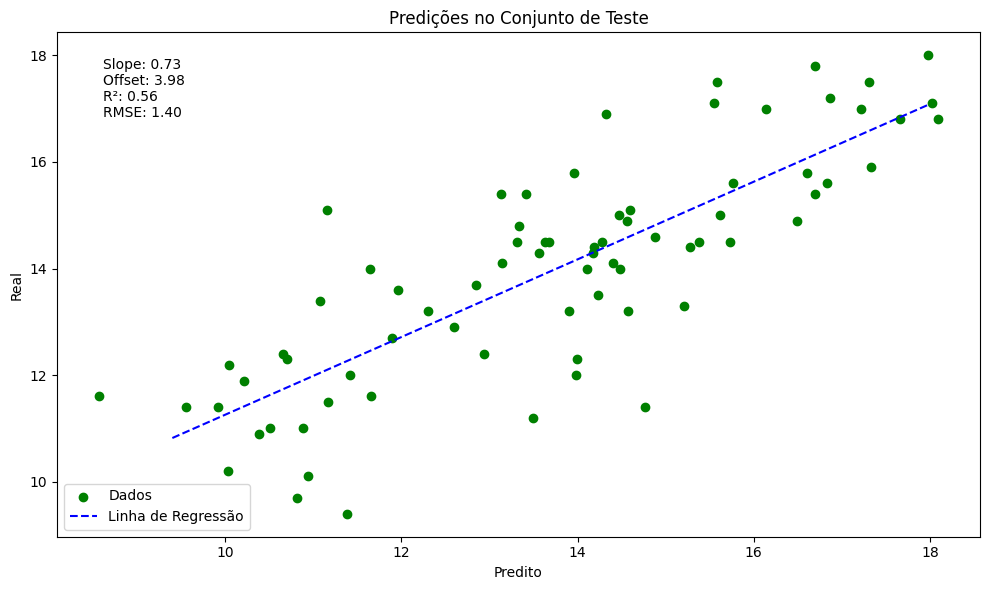

C:\Users\Luyza\AppData\Local\Temp\ipykernel_19288\1584603334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [128]:
results_msc_sst = MLPR(df_msc_cal.iloc[:, 6:], df_msc_cal['SST'].values, df_msc_val.iloc[:, 6:], df_msc_val['SST'].values, 'MSC', 'SST')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'SST')

=== Training Metrics ===
R²: 0.8786
Correlation coefficient: 0.9378
RMSE: 0.2043
MAE: 0.1379
Relative absolute error: 30.5234
Root relative squared error: 34.8397
Slope: 1.0277
Offset: -0.0242
=== Cross-Validation Metrics ===
R²: -0.0305
Correlation coefficient: 0.5122
RMSE: 0.5953
MAE: 0.4083
Relative absolute error: 90.3567
Root relative squared error: 101.5112
Slope: 0.5065
Offset: 0.6162
=== Validation Metrics ===
R²: 0.2494
Correlation coefficient: 0.6331
RMSE: 0.3789
MAE: 0.3011
Relative absolute error: 84.6675
Root relative squared error: 86.6367
Slope: 0.6746
Offset: 0.4284


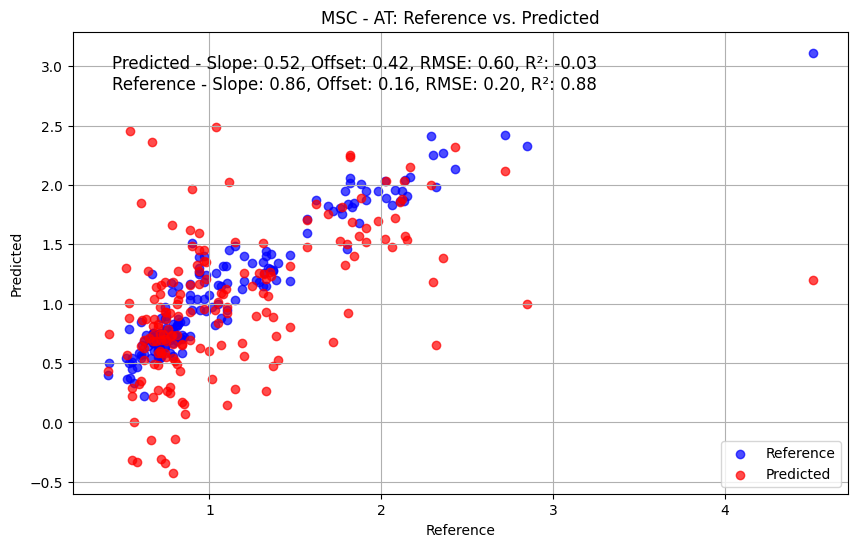

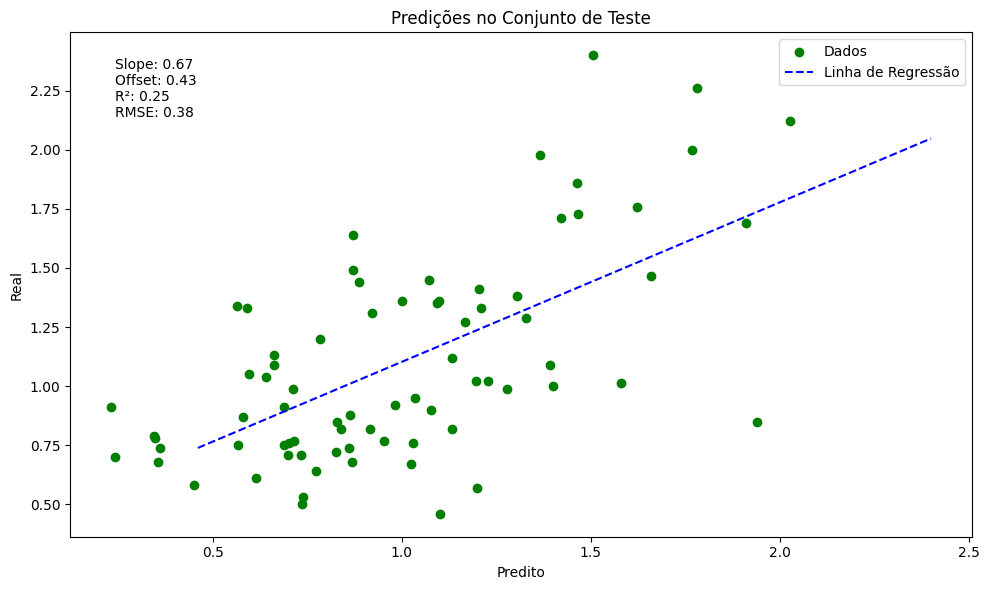

In [129]:
results_msc_at = MLPR(df_msc_cal.iloc[:, 6:], df_msc_cal['AT'].values, df_msc_val.iloc[:, 6:], df_msc_val['AT'].values, 'MSC', 'AT')
infos_msc = add_plot_infos(infos_msc, results_msc_at, 'AT')

=== Training Metrics ===
R²: 0.7344
Correlation coefficient: 0.8899
RMSE: 0.1589
MAE: 0.1231
Relative absolute error: 51.3058
Root relative squared error: 51.5354
Slope: 0.7929
Offset: 0.6946
=== Cross-Validation Metrics ===
R²: -2.7034
Correlation coefficient: 0.3234
RMSE: 0.5935
MAE: 0.4145
Relative absolute error: 172.7864
Root relative squared error: 192.4414
Slope: 0.1855
Offset: 2.7261
=== Validation Metrics ===
R²: -2.0126
Correlation coefficient: 0.5665
RMSE: 0.4574
MAE: 0.3456
Relative absolute error: 146.6575
Root relative squared error: 173.5685
Slope: 0.3189
Offset: 2.3202


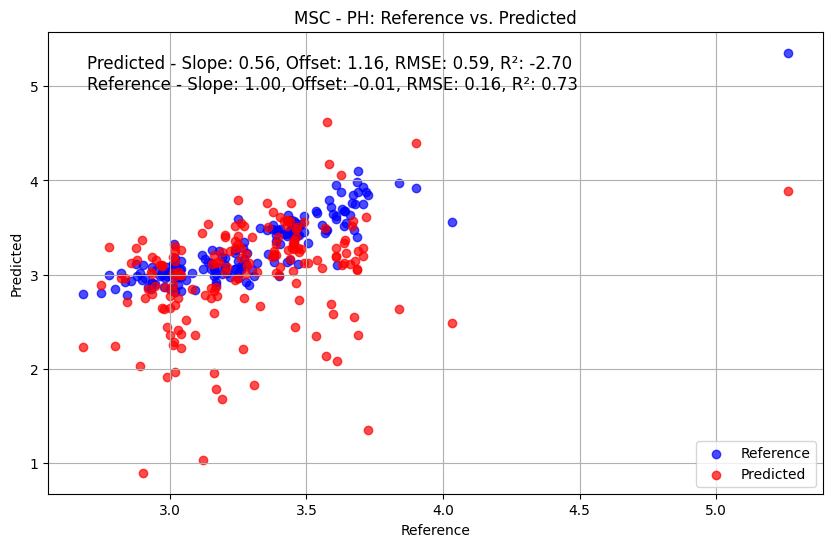

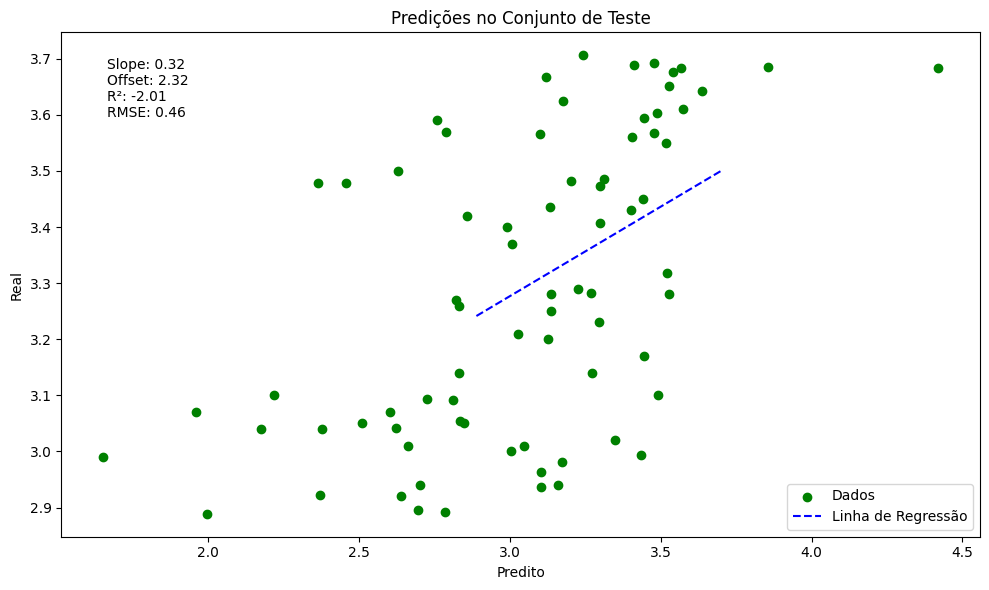

In [130]:
results_msc_ph = MLPR(df_msc_cal.iloc[:, 6:], df_msc_cal['PH'].values, df_msc_val.iloc[:, 6:], df_msc_val['PH'].values, 'MSC', 'PH')
infos_msc = add_plot_infos(infos_msc, results_msc_ph, 'PH')

In [ ]:
results_msc_firmeza = MLPR(df_msc_cal.iloc[:, 6:], df_msc_cal['FIRMEZA (N)'].values, df_msc_val.iloc[:, 6:], df_msc_val['FIRMEZA (N)'].values, 'MSC', 'FIRMEZA (N)')
infos_msc = add_plot_infos(infos_msc, results_msc_firmeza, 'FIRMEZA (N)')


c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


=== Training Metrics ===
R²: -21.1776
Correlation coefficient: 0.5469
RMSE: 483.9755
MAE: 472.9481
Relative absolute error: 567.9758
Root relative squared error: 470.9307
Slope: 681.3459
Offset: -26783.0603


c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


=== Training Metrics ===
R²: 0.7837
Correlation coefficient: 0.8884
RMSE: 1.4364
MAE: 0.5633
Relative absolute error: 24.5449
Root relative squared error: 46.5039
Slope: 1.0009
Offset: 0.2171
=== Cross-Validation Metrics ===
R²: 0.3447
Correlation coefficient: 0.6907
RMSE: 2.5002
MAE: 1.6356
Relative absolute error: 71.2700
Root relative squared error: 80.9475
Slope: 0.7148
Offset: 4.9042
=== Validation Metrics ===
R²: 0.6941
Correlation coefficient: 0.8900
RMSE: 1.4175
MAE: 1.0780
Relative absolute error: 49.1512
Root relative squared error: 55.3117
Slope: 0.7594
Offset: 3.9133


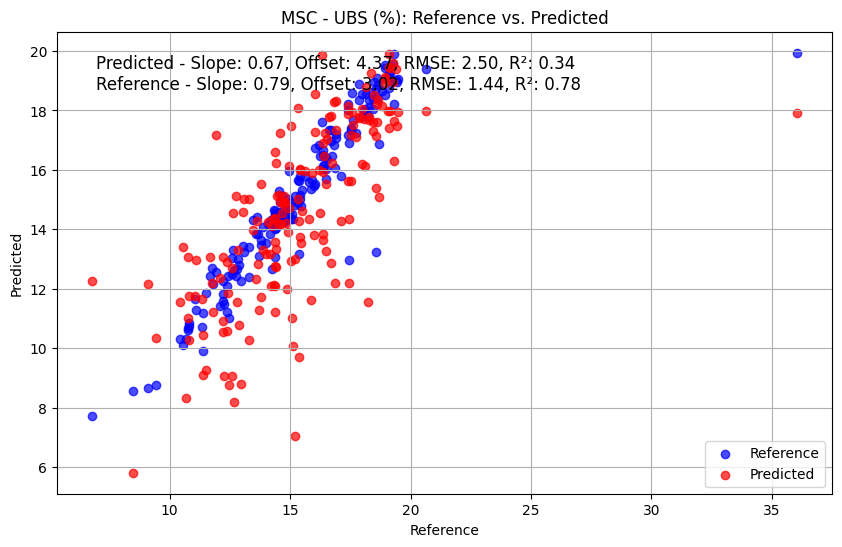

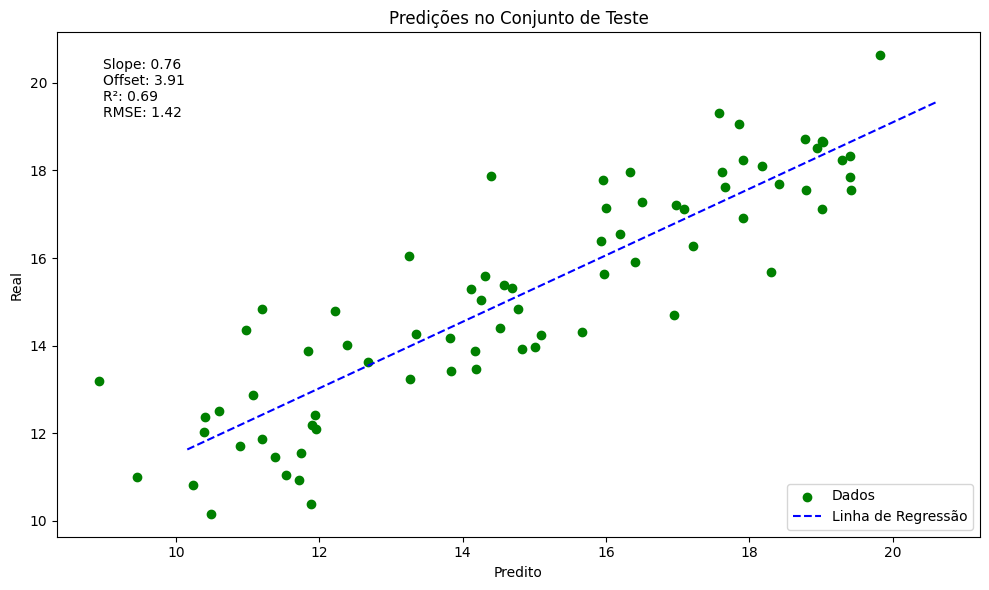

In [122]:
results_msc_ubs = MLPR(df_msc_cal.iloc[:, 6:], df_msc_cal['UBS (%)'].values, df_msc_val.iloc[:, 6:], df_msc_val['UBS (%)'].values, 'MSC', 'UBS (%)')
infos_msc = add_plot_infos(infos_msc, results_msc_ubs, 'UBS (%)')

In [123]:
infos_msc.to_excel('plot_infos_mlpr_msc.xlsx', index=False)
infos_msc

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.905373,0.953850,0.771106,0.561498,27.516483,30.761570,1.018546,-0.095793
1,SST,Cross-Validation,0.464998,0.764273,1.833511,1.465836,71.834028,73.143831,0.749607,3.951789
2,SST,Validation,0.766514,0.879683,1.204368,0.942598,44.751143,48.320441,0.918624,1.210117
3,AT,Training,0.894045,0.946775,0.179732,0.111210,27.449124,32.550749,1.049828,-0.043876
4,AT,Cross-Validation,-0.039202,0.569505,0.562879,0.400748,98.913319,101.941242,0.512222,0.605307
5,AT,Validation,0.508054,0.785897,0.369155,0.255782,56.469388,70.138848,0.706769,0.324393
6,PH,Training,0.888422,0.946216,0.104407,0.078305,31.605033,33.403304,0.932064,0.237409
7,PH,Cross-Validation,-6.330236,0.341617,0.846252,0.605662,244.452703,270.744086,0.140189,2.896748
8,PH,Validation,0.068211,0.664312,0.241887,0.172997,79.523345,96.529201,0.535188,1.544358
9,FIRMEZA (N),Training,-24.445438,-0.312061,485.795223,475.809364,627.930856,504.434713,-5.971625,717.195470


# Teste

In [4]:
X_test, y_test = df_msc_val.iloc[:,6:], df_msc_val['SST'].values
X_train, y_train = df_msc_cal.iloc[:,6:], df_msc_cal['SST'].values

In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Definir o pipeline
pipeline = make_pipeline(
    StandardScaler(),  # Normalização dos dados
    MLPRegressor(random_state=1, max_iter=1000)  # Rede Neural com iterações máximas
)

# Definir os parâmetros para o GridSearch
param_grid = {
    'mlpregressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Tamanhos das camadas ocultas
    'mlpregressor__activation': ['relu', 'tanh'],  # Função de ativação
    'mlpregressor__solver': ['adam', 'lbfgs'],  # Algoritmo de otimização
    'mlpregressor__alpha': [0.0001, 0.001],  # Regularização L2 (alpha)
    'mlpregressor__learning_rate': ['constant', 'adaptive'],  # Taxa de aprendizado
}

# Definir o GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Usando MAE como métrica de avaliação
    cv=10,  # Validação cruzada com 5 folds
    n_jobs=-1,  # Utiliza todos os processadores disponíveis
    verbose=3  # Mostra detalhes do processo
)

# Treinar o GridSearchCV
grid_search.fit(X_train, y_train)

# Resultados do GridSearch
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Fazer previsões no conjunto de teste usando o melhor modelo encontrado
y_pred = grid_search.predict(X_test)

# Calcular e exibir as métricas de desempenho
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nResultados no conjunto de teste:")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Melhores parâmetros encontrados:
{'mlpregressor__activation': 'tanh', 'mlpregressor__alpha': 0.001, 'mlpregressor__hidden_layer_sizes': (50, 50), 'mlpregressor__learning_rate': 'constant', 'mlpregressor__solver': 'lbfgs'}

Resultados no conjunto de teste:
MAE (Mean Absolute Error): 1.5991
RMSE (Root Mean Squared Error): 2.1579
R² (Coeficiente de Determinação): -0.0516


In [3]:
def testrfr(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "Correlation coefficient": correlation_coefficient,
            "Mean absolute error": mae,
            "Root mean squared error": rmse,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Total Number of Instances": len(y_true)
        }

    def display_metrics(title, metrics):
        print(f"\n=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val

    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        RandomForestRegressor(
            n_estimators=50,  # Número de árvores
            max_features='sqrt', # Usar raiz quadrada do número de características
            max_depth=20,    # Profundidade das árvores
            min_samples_split=2,  # Número mínimo de amostras necessárias para dividir um nó
            min_samples_leaf=1,   # Número mínimo de amostras necessárias em um nó folha
            bootstrap=True,    # Usar amostragem bootstrap
            oob_score=False,   # Não usar amostragem fora da bolsa
            random_state=1     # Semente aleatória
        )
    )

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results = []

    for metric, value in training_metrics.items():
        results.append({'Métrica': f'Training {metric}', 'Valor': value})
    
    for metric, value in cv_metrics.items():
        results.append({'Métrica': f'CV {metric}', 'Valor': value})
    
    for metric, value in validation_metrics.items():
        results.append({'Métrica': f'Validation {metric}', 'Valor': value})

    # Converter os resultados para um DataFrame
    results_df = pd.DataFrame(results)
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title("Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df
